# Microsoft Emotion API: Emotion analysis example

### This Jupyter notebook shows how to get started with the Project Oxford <b>Emotion API</b> in Python, and how to visualize the results.

To use this notebook, you will need to get keys to <b>Emotion API</b>. Visit <a href="http://www.projectoxford.ai/emotion">www.projectoxford.ai/emotion</a>, and then the “Try for free” button. On the “Sign in” page, use your Microsoft account to sign in and you will be able to subscribe to Emotion API and get free keys (Code of Conduct and TOS). After completing the sign-up process, paste your key into the variables section below. (Either the primary or the secondary key works.)

In [1]:
import time 
import requests
import cv2
import operator
import numpy as np
from __future__ import print_function
import random


# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 
# Display images within Jupyter

In [2]:
# Variables

_url = 'https://westus.api.cognitive.microsoft.com/emotion/v1.0/recognize'
_key = "7fdfca28bafc47919ea6a1d3131e8fc0" #Here you have to paste your primary key
_maxNumRetries = 10

## Helper functions

In [3]:
def processRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json()['error']['message'] ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json()['error']['message'] ) )

        break
        
    return result

In [4]:
from math import ceil
def renderResultOnImage( result, img ):
    """Display the obtained results onto the input image"""
    
    thickness = int(ceil(img.shape[0] / 100)) # thickness of the letters and the bounding box

    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = (255,0,0), thickness = thickness )


    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        currEmotion = max(currFace['scores'].items(), key=operator.itemgetter(1))[0]

        textToWrite = "%s" % ( currEmotion )
        font_size = 1.0 * img.shape[0] / 300
        
        cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-10), cv2.FONT_HERSHEY_SIMPLEX, font_size, (255,0,0), thickness )
        
    return currEmotion

## Detect faces from an image retrieved via URL

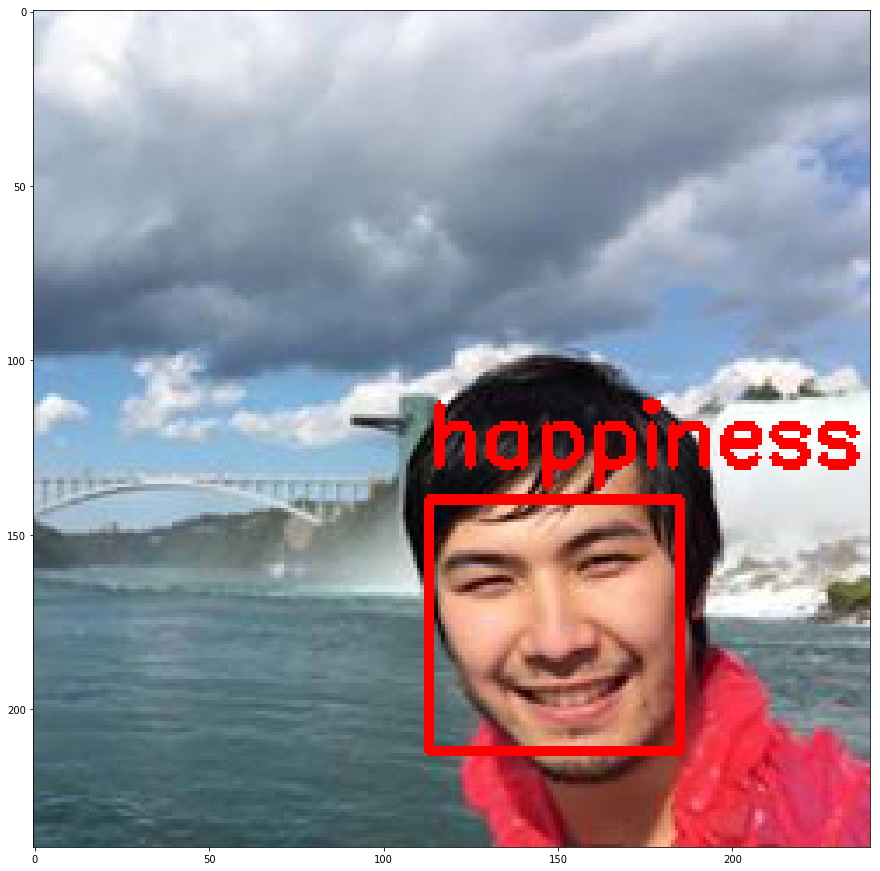

In [5]:
# URL direction to image
urlImage = 'https://scontent.fybz2-1.fna.fbcdn.net/v/t1.0-1/c66.0.240.240/p240x240/21032585_1605416669508769_4685254179131479441_n.jpg?oh=4435345ce1ef332ccf31865666d3764b&oe=5B0F5BD4&_nc_o2e=za8d36318&efg=eyJhZG1pc3Npb25fY29udHJvbCI6MSwidXBsb2FkZXJfaWQiOiIxMDAwMDEyMTM1NDc4MTcifQ%3D%3D'

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/json' 

json = { 'url': urlImage } 
data = None
params = None

result = processRequest( json, data, headers, params )

if result is not None:
    # Load the original image, fetched from the URL
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
    img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )

# Detect faces from an image stored on disk

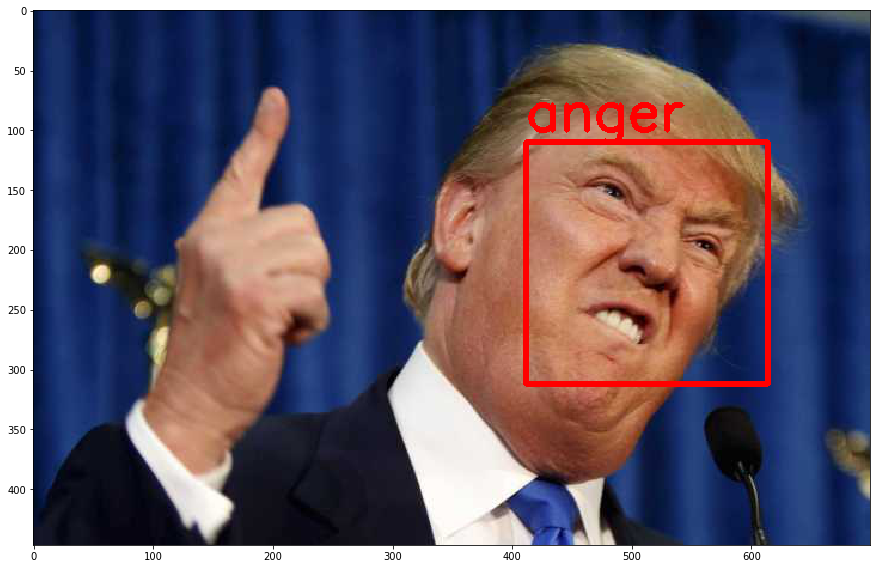

In [6]:
# Load raw image file into memory
pathToFileInDisk = 'trump.jpg'
with open( pathToFileInDisk, 'rb' ) as f:
    data = f.read()

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/octet-stream'

json = None
params = None

result = processRequest( json, data, headers, params )

if result is not None:
    # Load the original image from disk
    data8uint = np.fromstring( data, np.uint8 ) # Convert string to an unsigned int array
    img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )

# Emotion Recognition in a camera image

In [ ]:
import cv2
import time
from helpers import imshow

cam = cv2.VideoCapture(0)
time.sleep(0.1)
frame = cam.read()[1]
frame = cv2.flip(frame, 1)
cam.release()

bytes_string = cv2.imencode('.jpg', frame)[1].tostring()
result = processRequest( json, bytes_string, headers, params )

if result is not None:
    # Load the original image from disk
    data8uint = np.fromstring( bytes_string, np.uint8 ) # Convert string to an unsigned int array
    img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )
    
print (img.shape)

# Real-Time Emotion Recognition

### Note: Trial version of the Microsoft Emotion API allows to analyze emotions only in at most 20 images per minute

In [ ]:
camera = cv2.VideoCapture(0)
# reduce frame size to speed it up
w = 640
camera.set(cv2.CAP_PROP_FRAME_WIDTH, w) 
camera.set(cv2.CAP_PROP_FRAME_HEIGHT, w * 3/4) 
camera.set(cv2.CAP_PROP_EXPOSURE,-4) 
camera.set(cv2.CAP_PROP_FPS, 24)

i = 0
while True:
    
    # Get frame at flip it
    ret, frame = camera.read()
    frame = cv2.flip(frame, 1)
    bytes_string = cv2.imencode('.jpg', frame)[1].tostring()
    
    headers = dict()
    headers['Ocp-Apim-Subscription-Key'] = _key
    headers['Content-Type'] = 'application/octet-stream'

    json = None
    params = None
    
    result = processRequest( json, bytes_string, headers, params )
    

    if result is not None:
        data8uint = np.fromstring( bytes_string, np.uint8 ) # Convert string to an unsigned int array
        img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )
        renderResultOnImage( result, frame )
    
    cv2.imshow("Frame", frame)
    
    if cv2.waitKey(5) == 32:
        background_frame = frame
        background_captured = True
    elif cv2.waitKey(5) == 27:
        break  
    time.sleep(0.25)
    i += 1
    if i == 20:
        break
    
cv2.destroyAllWindows()
camera.release()
cv2.waitKey(1) # extra waitKey sometimes needed to close camera window
